In [1]:
%env CUDA_VISIBLE_DEVICES=4
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path += [
    "/home/lcw/openvla-oft",
    "/home/lcw/openvla-oft/vla-scripts",
]

import tensorflow_datasets as tfds
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from transformers import AutoProcessor

from finetune import (
    FinetuneConfig,
    RLDSBatchTransform_epi,
    ActionTokenizer,
    PurePromptBuilder,
)

# 설정
cfg = FinetuneConfig(
    vla_path="openvla/openvla-7b",
    data_root_dir=Path("/home/lcw/openvla-oft/datasets/modified_libero_rlds"),
    dataset_name="libero_10_no_noops",
    num_images_in_input=2,
    use_proprio=True,
    image_aug=False,
)

version_dir = cfg.data_root_dir / cfg.dataset_name / "1.0.0"
builder = tfds.builder_from_directory(version_dir)
builder.download_and_prepare()

processor = AutoProcessor.from_pretrained(cfg.vla_path, trust_remote_code=True)
action_tok = ActionTokenizer(processor.tokenizer)

batch_transform = RLDSBatchTransform_epi(
    action_tokenizer = action_tok,
    base_tokenizer   = processor.tokenizer,
    image_transform  = processor.image_processor.apply_transform,
    prompt_builder_fn= PurePromptBuilder,
    use_wrist_image  = cfg.num_images_in_input > 1,
    use_proprio      = cfg.use_proprio,
)

# 수정 1: 올바른 클래스 사용
from prismatic.vla.datasets.datasets import RLDSDataset_epi

train_dataset = RLDSDataset_epi(  #_epi 버전 사용
    data_root_dir       = cfg.data_root_dir,
    data_mix            = cfg.dataset_name,
    batch_transform     = batch_transform,
    resize_resolution   = tuple(processor.image_processor.input_sizes[0][1:]),
    shuffle_buffer_size = 100,
    train               = True,
    image_aug           = cfg.image_aug,
)

env: CUDA_VISIBLE_DEVICES=4


/home/lcw/miniconda3/envs/openvla-oft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-30 22:37:02.057348: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 22:37:02.096359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-30 22:37:02.096393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-30 22

Using LIBERO constants:
  NUM_ACTIONS_CHUNK = 8
  ACTION_DIM = 7
  PROPRIO_DIM = 8
  ACTION_PROPRIO_NORMALIZATION_TYPE = bounds_q99
If needed, manually set the correct constants in `prismatic/vla/constants.py`!


2025-06-30 22:37:20.474616: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


06/30 [22:37:20] INFO     | >> [*] Loading existing dataset statistics from                       ]8;id=613685;file:///home/lcw/openvla-oft/prismatic/vla/datasets/rlds/utils/data_utils.py\data_utils.py]8;;\:]8;id=78445;file:///home/lcw/openvla-oft/prismatic/vla/datasets/rlds/utils/data_utils.py#201\201]8;;\
                          /home/lcw/openvla-oft/datasets/modified_libero_rlds/libero_10_no_noops/                  
                          1.0.0/dataset_statistics_f1f4cb06e922a6979da3f480f311f18217dce47441ef4b                  
                          608b3eaaa06c950589.json.                                                                 

2025-06-30 22:37:21.062693: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


In [2]:
# 두 에피소드 메모리 그리드 분석 코드
print(" 두 에피소드 메모리 그리드 분석 시작 ")

episodes_data = {}
current_episode_id = None
episode_count = 0
max_episodes = 2
max_steps_per_episode = 10

print("에피소드별 샘플 수집 중...")

for i, sample in enumerate(train_dataset):
    episode_id = sample.get('episode_id', f'ep_{i}')
    step_in_episode = sample.get('step_in_episode', i)
    
    # 새로운 에피소드 시작 감지
    if episode_id != current_episode_id:
        current_episode_id = episode_id
        episode_count += 1
        episodes_data[episode_id] = []
        print(f"\n 에피소드 {episode_count} 시작: {episode_id}")
    
    # 현재 에피소드에 샘플 추가
    episodes_data[episode_id].append({
        'sample': sample,
        'step_in_episode': step_in_episode,
        'global_step': i
    })
    
    print(f"  Step {len(episodes_data[episode_id])}: Global {i}, Episode Step {step_in_episode}")
    
    # 에피소드당 최대 스텝 수 제한
    if len(episodes_data[episode_id]) >= max_steps_per_episode:
        print(f"  에피소드 {episode_id}: {max_steps_per_episode}개 스텝 수집 완료")
        
    # 최대 에피소드 수 도달시 종료
    if episode_count >= max_episodes:
        all_collected = all(len(data) >= max_steps_per_episode for data in episodes_data.values())
        if all_collected:
            break

print(f"\n 총 {len(episodes_data)}개 에피소드 수집 완료")
for ep_id, data in episodes_data.items():
    print(f"  {ep_id}: {len(data)}개 스텝")

# 메모리 그리드 시각화 함수 개선
def visualize_episode_memory_grids(episode_data, episode_name, max_display=8):
    """에피소드의 메모리 그리드 변화를 시각화"""
    
    print(f"\n=== {episode_name} 메모리 그리드 시각화 ===")
    
    steps_to_show = min(len(episode_data), max_display)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(steps_to_show):
        step_data = episode_data[i]
        sample = step_data['sample']
        step_num = step_data['step_in_episode']
        global_step = step_data['global_step']
        
        pixel_values = sample['pixel_values']
        
        # Primary camera 이미지 (메모리 그리드)
        if pixel_values.shape[0] >= 3:
            primary_img = pixel_values[:3]  # 첫 3채널 (RGB)
            
            # (C, H, W) -> (H, W, C) 변환
            img = primary_img.permute(1, 2, 0)
            
            # 정규화
            if img.max() > 1.0 or img.min() < 0.0:
                img = (img - img.min()) / (img.max() - img.min())
            
            # subplot에 그리기
            ax = axes[i]
            ax.imshow(img.cpu().numpy() if hasattr(img, 'cpu') else img)
            ax.set_title(f"Episode Step {step_num}\n(Global: {global_step})")
            ax.axis('off')
            
            # 메모리 그리드 구조 표시
            h, w = 224, 224
            # 4x4 그리드 라인
            for j in range(1, 4):
                ax.axhline(y=j*h/4, color='red', linestyle='--', alpha=0.6, linewidth=0.8)
                ax.axvline(x=j*w/4, color='red', linestyle='--', alpha=0.6, linewidth=0.8)
        
            
            # 과거 이미지 영역들 표시
            past_regions = [
                (0, 0, w/4, h/4),
                (3*w/4, 0, w/4, h/4),
                (0, 3*h/4, w/4, h/4),
                (3*w/4, 3*h/4, w/4, h/4)
            ]
            
            for j, (x, y, rw, rh) in enumerate(past_regions):
                rect = plt.Rectangle((x, y), rw, rh, 
                                   fill=False, edgecolor='cyan', linewidth=1, alpha=0.7)
                ax.add_patch(rect)
    
    # 빈 subplot 제거
    for i in range(steps_to_show, len(axes)):
        axes[i].remove()
    
    plt.tight_layout()
    plt.show()


 두 에피소드 메모리 그리드 분석 시작 
에피소드별 샘플 수집 중...
[EPISODE 1] Processing 233 steps
[FIRST EPISODE] Starting episode 1 with task: 'put the black bowl in the bottom drawer of the cab...'
[EPISODE TRANSITION] None -> libero_10_no_noops_ep_1

 에피소드 1 시작: libero_10_no_noops_ep_1
  Step 1: Global 0, Episode Step 1
  Step 2: Global 1, Episode Step 2
  Step 3: Global 2, Episode Step 3
  Step 4: Global 3, Episode Step 4
  Step 5: Global 4, Episode Step 5
  Step 6: Global 5, Episode Step 6
  Step 7: Global 6, Episode Step 7
  Step 8: Global 7, Episode Step 8
  Step 9: Global 8, Episode Step 9
[STEP 10] Episode libero_10_no_noops_ep_1: 8 primary + 8 wrist → dual memory grid
  Step 10: Global 9, Episode Step 10
  에피소드 libero_10_no_noops_ep_1: 10개 스텝 수집 완료
  Step 11: Global 10, Episode Step 11
  에피소드 libero_10_no_noops_ep_1: 10개 스텝 수집 완료
  Step 12: Global 11, Episode Step 12
  에피소드 libero_10_no_noops_ep_1: 10개 스텝 수집 완료
  Step 13: Global 12, Episode Step 13
  에피소드 libero_10_no_noops_ep_1: 10개 스텝 수집 완료
  Step 

In [3]:
# 각 에피소드별 메모리 그리드 시각화
episode_names = list(episodes_data.keys())


 첫 번째 에피소드 분석

=== Episode 1: libero_10_no_noops_ep_1 메모리 그리드 시각화 ===


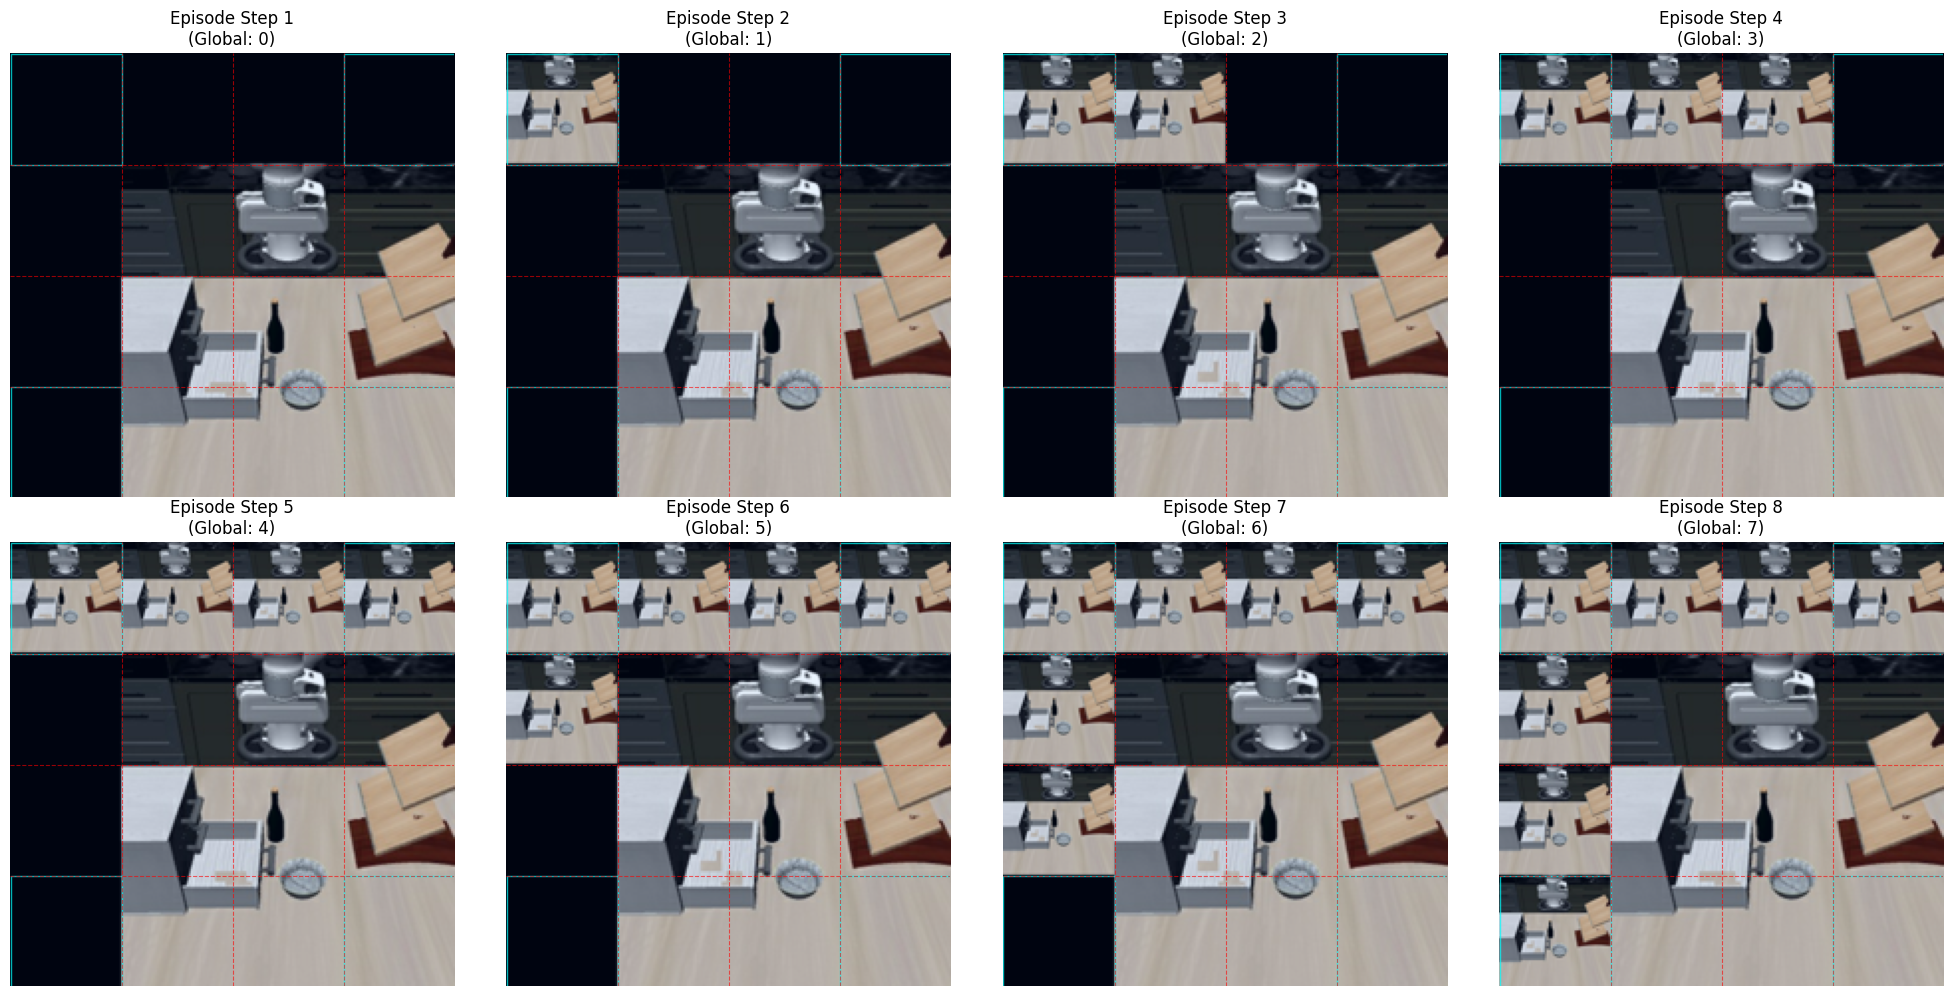

In [4]:

if len(episode_names) >= 1:
    print("\n" + "="*60)
    print(" 첫 번째 에피소드 분석")
    print("="*60)
    visualize_episode_memory_grids(episodes_data[episode_names[0]], f"Episode 1: {episode_names[0]}")



 두 번째 에피소드 분석

=== Episode 2: libero_10_no_noops_ep_2 메모리 그리드 시각화 ===


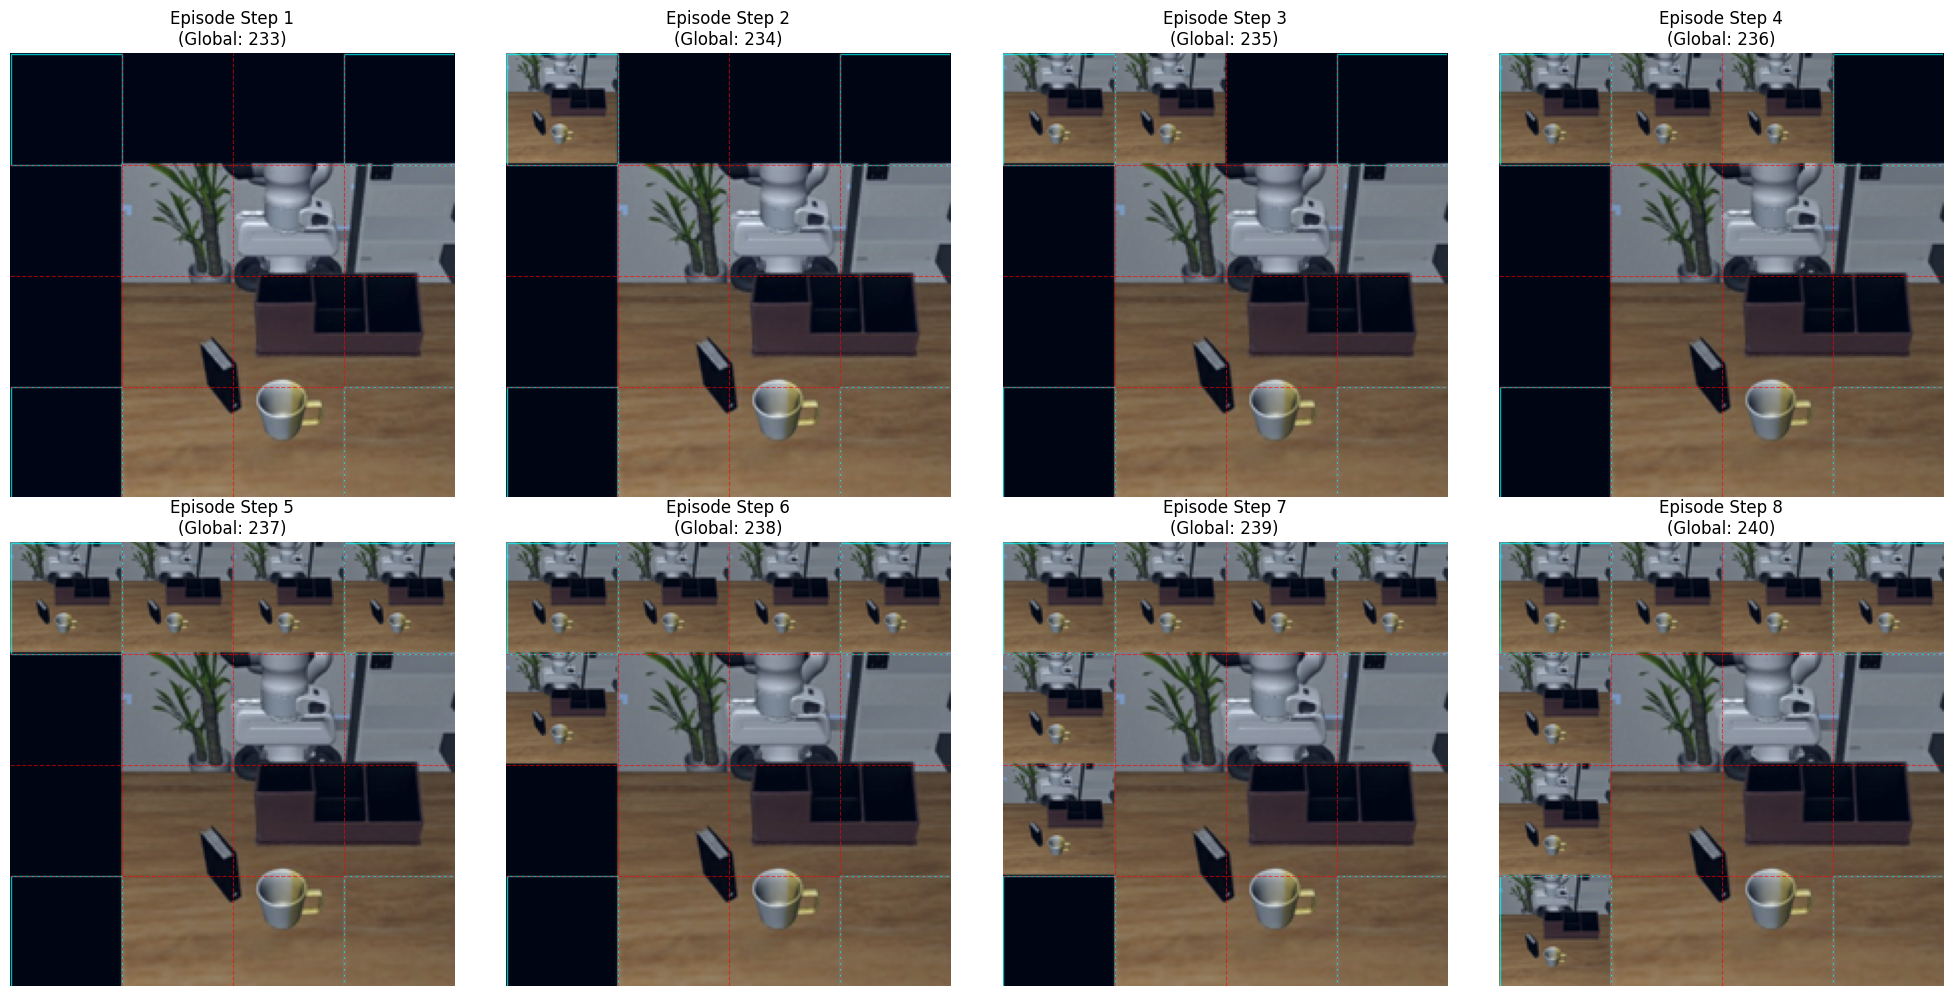

In [5]:

if len(episode_names) >= 2:
    print("\n" + "="*60)
    print(" 두 번째 에피소드 분석")  
    print("="*60)
    visualize_episode_memory_grids(episodes_data[episode_names[1]], f"Episode 2: {episode_names[1]}")


In [6]:

# 에피소드 전환 지점에서의 배치 변환기 상태 확인
print("\n=== 배치 변환기 에피소드 전환 분석 ===")

# 에피소드 전환 지점 확인
if len(episode_names) >= 2:
    ep1_last_step = episodes_data[episode_names[0]][-1]
    ep2_first_step = episodes_data[episode_names[1]][0]
    
    print(f"에피소드 1 마지막 스텝: {ep1_last_step['global_step']}")
    print(f"에피소드 2 첫 번째 스텝: {ep2_first_step['global_step']}")
    
    # 배치 변환기 상태 정보
    print(f"\n현재 배치 변환기 상태:")
    current_info = batch_transform.get_current_episode_info()
    print(f"  현재 에피소드: {current_info}")
    
    episode_stats = batch_transform.get_episode_stats()
    print(f"\n에피소드별 통계:")
    for ep_id, stats in episode_stats.items():
        print(f"  {ep_id}: {stats}")



=== 배치 변환기 에피소드 전환 분석 ===
에피소드 1 마지막 스텝: 232
에피소드 2 첫 번째 스텝: 233

현재 배치 변환기 상태:
  현재 에피소드: {'current_episode_id': 'libero_10_no_noops_ep_2', 'episode_counter': 2, 'step_counter': 10, 'global_step_counter': 243, 'prev_task': 'pick up the book and place it in the back compartm...', 'num_episodes_in_memory': 2, 'use_wrist_image': True}

에피소드별 통계:
  libero_10_no_noops_ep_1: {'num_images': 8, 'num_wrist_images': 8, 'is_current': False, 'max_capacity': 8}
  libero_10_no_noops_ep_2: {'num_images': 8, 'num_wrist_images': 8, 'is_current': True, 'max_capacity': 8}



=== 두 번째 에피소드: 첫 번째 vs 마지막 스텝 비교 ===


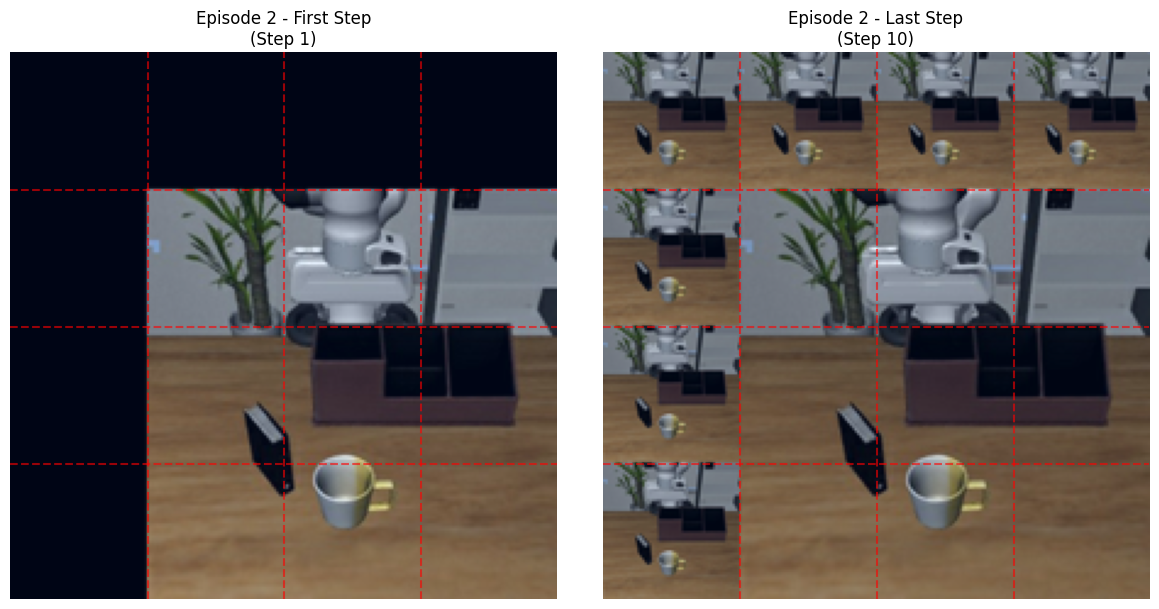

 정상 작동하는 경우:
  - 두 번째 에피소드 첫 스텝: 중앙에만 현재 이미지, 과거 영역은 비어있음
  - 두 번째 에피소드 진행: 과거 이미지들이 점진적으로 작은 타일로 누적
  - 에피소드별로 메모리가 독립적으로 관리됨

 문제가 있는 경우:
  - 두 번째 에피소드 첫 스텝에 이전 에피소드 이미지가 남아있음
  - 메모리 그리드가 전혀 변화하지 않음
  - 과거 이미지 영역이 제대로 채워지지 않음


In [7]:

# 두 번째 에피소드의 첫 번째와 마지막 스텝 비교
if len(episode_names) >= 2 and len(episodes_data[episode_names[1]]) > 1:
    print("\n=== 두 번째 에피소드: 첫 번째 vs 마지막 스텝 비교 ===")
    
    ep2_data = episodes_data[episode_names[1]]
    first_step = ep2_data[0]['sample']
    last_step = ep2_data[-1]['sample']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # 첫 번째 스텝
    pixel_values_first = first_step['pixel_values'][:3].permute(1, 2, 0)
    if pixel_values_first.max() > 1.0 or pixel_values_first.min() < 0.0:
        pixel_values_first = (pixel_values_first - pixel_values_first.min()) / (pixel_values_first.max() - pixel_values_first.min())
    
    axes[0].imshow(pixel_values_first.cpu().numpy() if hasattr(pixel_values_first, 'cpu') else pixel_values_first)
    axes[0].set_title(f"Episode 2 - First Step\n(Step {ep2_data[0]['step_in_episode']})")
    axes[0].axis('off')
    
    # 그리드 라인
    for j in range(1, 4):
        axes[0].axhline(y=j*224/4, color='red', linestyle='--', alpha=0.6)
        axes[0].axvline(x=j*224/4, color='red', linestyle='--', alpha=0.6)
    
    # 마지막 스텝
    pixel_values_last = last_step['pixel_values'][:3].permute(1, 2, 0)
    if pixel_values_last.max() > 1.0 or pixel_values_last.min() < 0.0:
        pixel_values_last = (pixel_values_last - pixel_values_last.min()) / (pixel_values_last.max() - pixel_values_last.min())
    
    axes[1].imshow(pixel_values_last.cpu().numpy() if hasattr(pixel_values_last, 'cpu') else pixel_values_last)
    axes[1].set_title(f"Episode 2 - Last Step\n(Step {ep2_data[-1]['step_in_episode']})")
    axes[1].axis('off')
    
    # 그리드 라인
    for j in range(1, 4):
        axes[1].axhline(y=j*224/4, color='red', linestyle='--', alpha=0.6)
        axes[1].axvline(x=j*224/4, color='red', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()


print(" 정상 작동하는 경우:")
print("  - 두 번째 에피소드 첫 스텝: 중앙에만 현재 이미지, 과거 영역은 비어있음")
print("  - 두 번째 에피소드 진행: 과거 이미지들이 점진적으로 작은 타일로 누적")
print("  - 에피소드별로 메모리가 독립적으로 관리됨")
print("\n 문제가 있는 경우:")
print("  - 두 번째 에피소드 첫 스텝에 이전 에피소드 이미지가 남아있음")
print("  - 메모리 그리드가 전혀 변화하지 않음")
print("  - 과거 이미지 영역이 제대로 채워지지 않음")
